In [1]:
# General Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns


# My Modules
import shap as shap
from wilkeXAI.data_generator import DataGenerator
import wilkeXAI.wilke_shap as fwg
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [2]:
def eom(u, t, params = {}):
    """
        Duffing Oscillator Equation of Motion

        ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)

        Input
        ----------
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        alpha : float, linear stiffness
        beta  : float, non linearity in the restoring force
        gamma : float, amplitude of the periodic driving force
        delta : float, amount of damping
        omega : float, angular frequency of the periodic driving force

        Returns
        ----------
        [dx,ddx] : Tuple, Time derivatives of 
                    position and velocity at time t

    """
    x, dx = u[0], u[1]
    ddx = (params['gamma'] * np.cos(params['omega'] * t) - 
           (params['delta'] * dx + params['alpha'] * x + params['beta'] * x**3))

    return [dx,ddx]

In [32]:
def generate(num_samples = int(5e1), delay=0, samples=10, end_time=100):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        parameters = {
                      'alpha': [np.linspace(-1,-1,1)],
                      'beta': [np.linspace(1,1,1)],
                      'gamma': [np.linspace(0.37,0.37,1)],
                      'delta': [np.linspace(1,1,1)],
                      'omega': [np.linspace(1.2,1.2,1)]
                     }
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays
        parameter_length = 1
        labels = ['xt','vt']
        for key in parameters:
            parameter_length  *= len(parameters[key][0])
        complete_feature_vec = ['x0','v0','t','rand']
        for k in parameters:
            complete_feature_vec.append(k)  
        X = np.empty((num_samples*parameter_length*samples, (len(complete_feature_vec))))
        y = np.empty((num_samples*parameter_length*samples, len(labels)))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = [int(100/samples*i) for i in range(samples)]
        #Generate num_samples samples
        ticker = 0
        for alpha in parameters['alpha'][0]:
            for beta in parameters['beta'][0]:
                for gamma in parameters['gamma'][0]:
                    for delta in parameters['delta'][0]:
                        for omega in parameters['omega'][0]:
                            current_params = {'alpha' : alpha,'beta' : beta, 'delta' : delta, 
                                                       'gamma' :gamma, 'omega' : omega}
                            
                             
                            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                                #Generate random starting positions
                                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                                v0 = (v_max - v_min) * np.random.random_sample() + v_min 
                                #Generate a trajectory
                                func = lambda u,t: eom(u, t, params = current_params)
                                trajectory = odeint(func, [x0,v0], t_range)
                                for j, t_ind in enumerate(t_vals):
                                    X[j+i*samples+ticker*num_samples*samples,:] = [x0, v0, t_range[t_ind], np.random.sample(), 
                                                                            alpha, beta, gamma, delta, omega]
                                    y[j+i*samples+ticker*num_samples*samples,:] = trajectory[t_ind,:]
                            ticker +=1        
                                    
                                    
        
        
        X_df = pd.DataFrame(X, columns = complete_feature_vec)
        y_df = pd.DataFrame(y, columns = labels)
        return X_df, y_df, complete_feature_vec, labels

In [4]:
suffix = "testing"

In [34]:
X, y, features, labels = generate(num_samples = int(1e3))

Generating Data…: 100%|████████████████| 1000/1000 [00:13<00:00, 75.84it/s]


In [59]:
X

,x0,v0,t,rand,alpha,beta,gamma,delta,omega
0,0.572863,1.117819,0.0,0.761786,-1.0,1.0,0.37,0.0,1.2
1,0.572863,1.117819,10.0,0.189480,-1.0,1.0,0.37,0.0,1.2
2,0.572863,1.117819,20.0,0.397393,-1.0,1.0,0.37,0.0,1.2
3,0.572863,1.117819,30.0,0.411166,-1.0,1.0,0.37,0.0,1.2
4,0.572863,1.117819,40.0,0.154347,-1.0,1.0,0.37,0.0,1.2
...,...,...,...,...,...,...,...,...,...
19995,0.357488,1.850208,50.0,0.418759,-1.0,1.0,0.37,1.0,1.2
19996,0.357488,1.850208,60.0,0.659587,-1.0,1.0,0.37,1.0,1.2
19997,0.357488,1.850208,70.0,0.374845,-1.0,1.0,0.37,1.0,1.2
19998,0.357488,1.850208,80.0,0.089822,-1.0,1.0,0.37,1.0,1.2


In [35]:
scaler = MinMaxScaler(feature_range=[-2,2])

X_data = pd.DataFrame(scaler.fit_transform(X), columns=features)

In [36]:
def true_predict(X):
    if type(X) == pd.core.frame.DataFrame:
        X = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X)[0], 2))
    for i in range(0,np.shape(X)[0]):
        func = lambda u,t: eom(u, t, params = {'alpha' : X['alpha'].iloc[i],
                                           'beta' : X['beta'].iloc[i],
                                           'gamma' :X['gamma'].iloc[i],
                                           'delta' : X['delta'].iloc[i],
                                           'omega' : X['omega'].iloc[i]})
        t_range = np.linspace(0, X['t'].iloc[i], 100, endpoint=False)
        y[i,:] = odeint(func, [X['x0'].iloc[i], X['v0'].iloc[i]], t_range)[-1]
    return y   

In [37]:
background = shap.sample(X_data, 100)

In [38]:
shap_explainer = shap.KernelExplainer(true_predict, background)

In [39]:
X_sorted = X_data.sort_values(by=['x0'])

choice = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 100, replace =False))]




In [54]:
choice

,x0,v0,t,rand,alpha,beta,gamma,delta,omega
13752,-1.993588,-1.087550,-1.111111,0.923035,-2.0,-2.0,-2.0,2.0,-2.0
5424,-1.947502,-1.838493,-0.222222,-0.566645,-2.0,-2.0,-2.0,-2.0,-2.0
2864,-1.906236,0.842017,-0.222222,1.569918,-2.0,-2.0,-2.0,-2.0,-2.0
13016,-1.860447,0.992802,0.666667,1.887875,-2.0,-2.0,-2.0,2.0,-2.0
18934,-1.839053,0.563325,-0.222222,-1.091648,-2.0,-2.0,-2.0,2.0,-2.0
...,...,...,...,...,...,...,...,...,...
6968,1.732155,-0.756984,1.555556,-0.897453,-2.0,-2.0,-2.0,-2.0,-2.0
1182,1.751539,-0.322670,-1.111111,0.464047,-2.0,-2.0,-2.0,-2.0,-2.0
13160,1.836568,-0.079397,-2.000000,0.838664,-2.0,-2.0,-2.0,2.0,-2.0
7311,1.904699,0.914673,-1.555556,-1.231311,-2.0,-2.0,-2.0,-2.0,-2.0


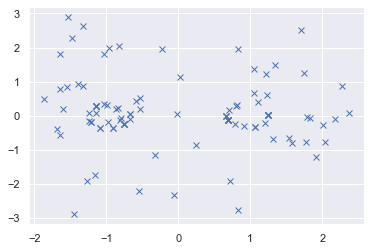

In [58]:
plt.plot(y.iloc[choice.index]['xt'],y.iloc[choice.index]['vt'],'x')

In [41]:
X_shap_values = shap_explainer.shap_values(choice)

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
X_shap_values[1]

array([[-5.08350876e-02, -4.06034364e-02,  2.31126740e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.71306390e-02,  0.00000000e+00],
       [-9.57698890e-01, -3.13317573e-01, -5.35261316e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.43925090e-01,  0.00000000e+00],
       [-8.30995621e-01, -4.23034425e-01, -8.86962552e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.73076152e-01,  0.00000000e+00],
       [ 8.67752453e-02,  1.28289983e-01, -2.25006711e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.00359032e-01,  0.00000000e+00],
       [ 1.01906978e-01,  5.04909953e-02, -1.45386136e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.56927334e-01,  0.00000000e+00],
       [ 1.26641195e-01,  9.27287003e-02, -1.89928924e-01,
         0.00000000e+00,  0.00000000e+00,  0.000000

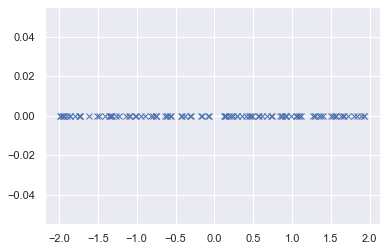

In [49]:
plt.plot(choice['rand'], X_shap_values[1][:,3],'x')

In [51]:
lime_explainer = shap.other.LimeTabular(true_predict, background, mode="regression")

In [62]:
X_lime_values = lime_explainer.attributions(choice)

In [45]:
models = {'ml': true_model}

In [46]:
shap_exp = fwg.wilke_explainer(models, X_exp, X_exp, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='shap', background_resolution=100, tolerance=2)

In [47]:
shap_exp.eval_explainer()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,,,,x0,v0,t,rand,alpha,beta,gamma,delta,omega
num,feature,contribution,model,,,,,,,,,
0,x0,xt,ml,0.974175,0.009153,0.319542,0.0,0.0,0.0,0.0,0.0,0.0
1,x0,xt,ml,0.881571,0.094095,0.231594,0.0,0.0,0.0,0.0,0.0,0.0
2,x0,xt,ml,0.886235,0.094706,0.283503,0.0,0.0,0.0,0.0,0.0,0.0
3,x0,xt,ml,0.975932,-0.000095,0.231423,0.0,0.0,0.0,0.0,0.0,0.0
4,x0,xt,ml,-0.427818,-0.482664,0.268088,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,omega,vt,ml,0.017997,0.017619,-0.114530,0.0,0.0,0.0,0.0,0.0,0.0
96,omega,vt,ml,0.021289,-0.000377,0.245801,0.0,0.0,0.0,0.0,0.0,0.0
97,omega,vt,ml,0.013871,0.029744,0.177137,0.0,0.0,0.0,0.0,0.0,0.0


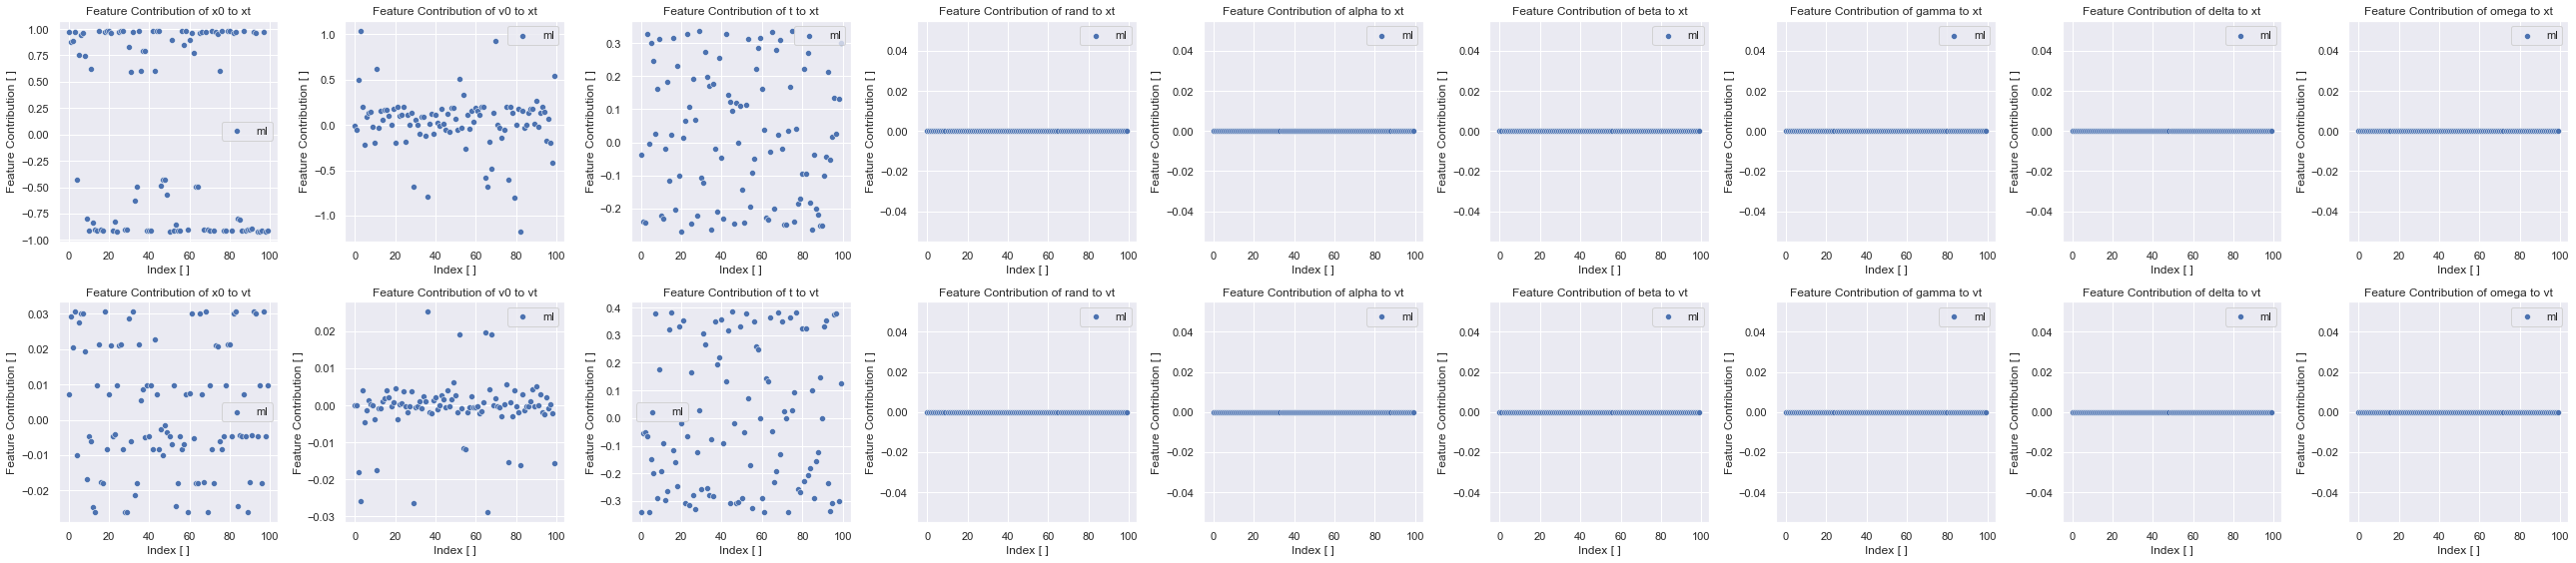

In [48]:
shap_exp.exp_plot()

In [ ]:
lime_exp = fwg.wilke_explainer(models, X_exp, X_exp, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='lime', background_resolution=100, tolerance=2)

lime_exp.eval_explainer()

lime_exp.exp_plot()

In [ ]:
anal_exp = fwg.wilke_explainer(models, X_exp, X_exp, y, suffix = suffix, data_tol=0.1, num_vals=100, 
                 explainer_type='analytic', background_resolution=100, tolerance=2)

anal_exp.eval_explainer()

anal_exp.exp_plot()

In [ ]:
def agg_plot(agg_vals, test_labels, explainer_type='shap', models=models):
    """
        Plotting routine to visualise the aggregated feature importance.
    """
    f, axs = plt.subplots(len(models), test_labels.shape[1], 
                          figsize=(6*test_labels.shape[1], 4*len(models)), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_labels.shape[1]))))

    for i, __model in enumerate(models):
        for j, __contribution in enumerate(test_labels):
            sns.barplot(data = agg_vals.xs((__contribution, __model), level=('contribution', 'model')),
                x = agg_vals.xs((__contribution, __model), level=('contribution', 'model')).index,
                y = 'contrib', label = __model, ax=axs[i,j])
            axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
            axs[i,j].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()
    f.savefig("Images/"+explainer_type+"_aggregated"+suffix+".svg", dpi='figure')

In [ ]:
anal_agg = anal_agg.set_index(['feature', 'contribution', 'model'])

In [ ]:
agg_plot(anal_agg, y_test, explainer_type='analytic')

In [ ]:
def exp_plot(feature_attributions, test_labels, test_data, models=models, explainer_type='shap'):
    """
        Plotting routine to visualise the explainers' results. Plots individual
        feature contribution for each model and each feature.
    """
    f, axs = plt.subplots(test_labels.shape[1], test_data.shape[1], 
                          figsize=(4*test_data.shape[1], 8), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_data.shape[1]))))

    for i, __feature in enumerate(test_data.columns):
        for j, __contribution in enumerate(test_labels.columns):
            for __model in models:
                sns.scatterplot(data = feature_attributions.xs((__feature, __contribution, __model), 
                                                  level=('feature', 'contribution', 'model')), 
                                x = feature_attributions.xs((__feature, __contribution, 'true'), 
                                               level=('feature', 'contribution', 'model')).index,
                                y = feature_attributions.xs((__feature, __contribution, __model), 
                                             level=('feature', 'contribution', 'model'))[__feature],
                                label = __model, ax=axs[j,i])  

            axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
            axs[j,i].set_xlabel('Index [ ]')
            axs[j,i].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()

    f.savefig("Images/"+explainer_type+"_summary"+suffix+"_kernel_good.svg", dpi='figure')

In [ ]:
exp_plot(lime_indiv, y_test, X_test, models=models, explainer_type='lime')

In [2]:
"""
Define and Machine Learning Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model


In [3]:
suffix = "Run_1"
generator = DataGenerator()
# Generate the data
X_train, y_train = generator.generate(num_samples=int(1e4))
X_test, y_test = generator.generate(num_samples=int(1e3))

NameError: name 'DataGenerator' is not defined

In [ ]:
X_train.loc[:,'x0':'t']

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train.loc[:,'x0':'t'].values)
scaler.transform(X_train.loc[:,'x0':'t'].values, copy=False)
scaler.transform(X_test.loc[:,'x0':'t'].values, copy = False)

In [ ]:
X_test.iloc[:,:3]

In [ ]:
if type(X_test.values) == np.ndarray:
    print('bleh')

In [ ]:
model = MLModel()
true_model = fwg.TrueModel(scaler, X_test)

In [ ]:
# Train Network
# Model Weights Path
checkpoint_path = "Networks//training//"+suffix+"cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = [cp_callback,
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]


history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=3, 
                  validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=2)

In [ ]:
X_test.columns[:4]

In [ ]:
models = {'ml': model, 
         'true': true_model}
       
for exp_type in ['shap', 'lime', 'analytic']:
    explainer_curr = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type=exp_type, tolerance = 1)
    explainer_curr.eval_explainer().to_csv("Results/"+exp_type+"/individual/"+suffix+".csv")
    explainer_curr.aggregate().to_csv("Results/"+exp_type+"/aggregate/"+suffix+".csv")

In [ ]:
explainer_test = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type='shap', tolerance = 0.1)

In [ ]:
choose_vals(0,9)

In [ ]:
def choose_vals(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        data_arr = X_test.iloc[np.where(vals < 0.1)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        return where__
    

In [ ]:
def choose_data(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        
        print(vals)
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr

In [ ]:
where__ = np.ones_like(data_arr.values[:,i], dtype=bool)

In [ ]:
params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}

In [ ]:
for beta in params['gamma']:
    print(beta)

In [ ]:
X_test.set_index(['alpha', 'beta', 'gamma', 'delta', 'omega'])

In [ ]:
X_test = scaler.inverse_transform(X_test)

In [ ]:
X_test